In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
plt.style.use("bmh")
plt.rcParams['figure.figsize'] = (10,6)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 60)
pd.set_option("display.precision", 2)

### 1. Data

In [2]:
customers = pd.read_csv('Mall_Customers.csv')
customers

,CustomerID,Genre,Age,Annual_Income_(k$),Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


### 2. Data Overview

In [3]:
customers.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual_Income_(k$)', 'Spending_Score'], dtype='object')

In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CustomerID          200 non-null    int64 
 1   Genre               200 non-null    object
 2   Age                 200 non-null    int64 
 3   Annual_Income_(k$)  200 non-null    int64 
 4   Spending_Score      200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
customers.describe()

,CustomerID,Age,Annual_Income_(k$),Spending_Score
count,200.00,200.00,200.00,200.00
mean,100.50,38.85,60.56,50.20
std,57.88,13.97,26.26,25.82
min,1.00,18.00,15.00,1.00
25%,50.75,28.75,41.50,34.75
50%,100.50,36.00,61.50,50.00
75%,150.25,49.00,78.00,73.00
max,200.00,70.00,137.00,99.00


In [6]:
customers.isna().sum()

CustomerID            0
Genre                 0
Age                   0
Annual_Income_(k$)    0
Spending_Score        0
dtype: int64

In [7]:
customers.duplicated().sum()

0

### 2. Data Wrangling

In [8]:
# We are going to do three things: first set the column 	CustomerID	 as the index column,
# and second we are going to put the name of all the columns in lowercase,
# and finally we are goin to rename some columns
customers.set_index('CustomerID', inplace=True)
customers.columns = [x.lower() for x in customers.columns]
customers.rename(columns={'annual_income_(k$)':'Income', 'spending_score':'score'}, inplace=True)
customers

,genre,age,Income,score
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


### 3. Data Analysis

In [9]:
# Let's check the correlation in the data
customers_corr = customers.corr()
customers_corr

,age,Income,score
age,1.00,-1.24e-02,-3.27e-01
Income,-0.01,1.00e+00,9.90e-03
score,-0.33,9.90e-03,1.00e+00


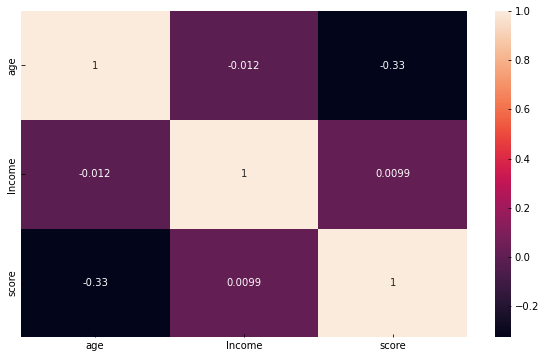

In [10]:
# All the correlation are very low
# It doesn't worth value analyze the relationship between variables, we should focus on invidual analysis
sns.heatmap(customers_corr, annot=True);

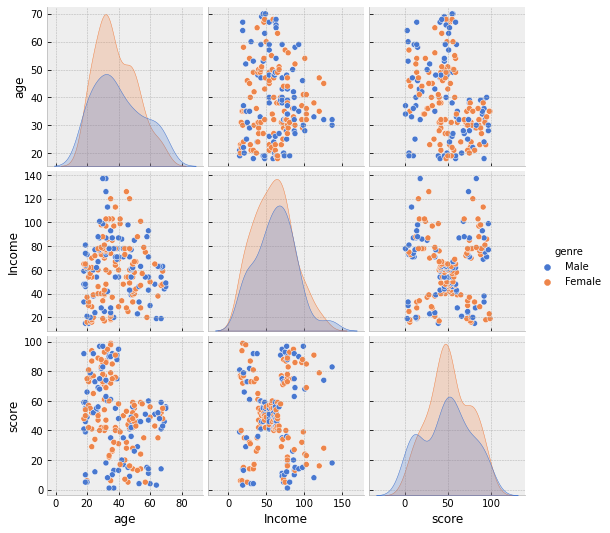

In [11]:
# We can even see this simultaneously with a pairplot
sns.pairplot(customers, hue='genre', palette='muted');

In [12]:
# Let's group by genre, to see if we can catch something useful
# The data for male and female looks very similar
customers.groupby('genre').agg(['max', 'min', 'mean'])

age            Income            score           
       max min   mean    max min   mean   max min   mean
genre                                                   
Female  68  18  38.10    126  16  59.25    99   5  51.53
Male    70  18  39.81    137  15  62.23    97   1  48.51

<AxesSubplot:ylabel='Frequency'>

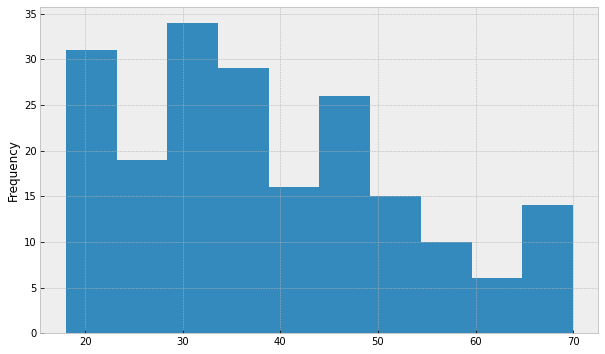

In [13]:
# When the data is very similar, we can use histograms to see patterns
customers['age'].plot.hist()

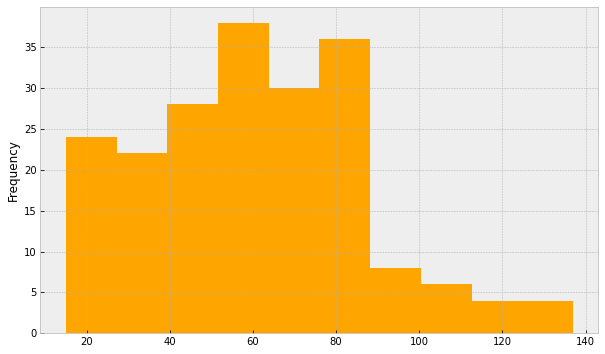

In [14]:
customers['Income'].plot.hist(color='orange');

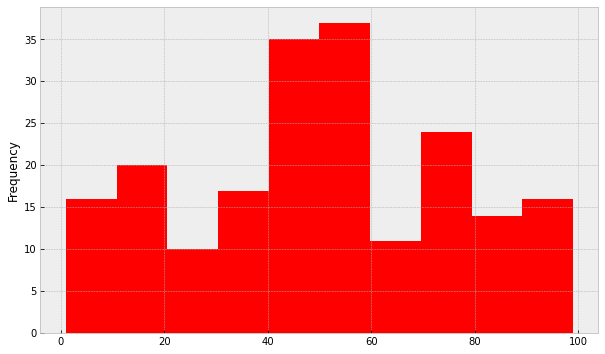

In [15]:
customers['score'].plot.hist(color='red');

In [16]:
# Number of costumer with high income and high score
# There is just one customer in that condition
customers.query('Income >= 100 and score >= 90')

,genre,age,Income,score
CustomerID,,,,
194,Female,38,113,91


### Cluster Analsyis

In [17]:
# As variables seems to be uncorrelated it could be useful to apply cluster
# and create groups withtin the data
from sklearn.cluster import KMeans


# Prepare data for clustering
X = customers[['age', 'Income', 'score']] # select the features to be used
X_scaled = (X - X.mean()) / X.std() # standardize the data

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_scaled) # set the number of clusters
customers['cluster'] = kmeans.predict(X_scaled) # add cluster labels to original dataframe

In [19]:
# Check how many individuals are in each cluster
customers['cluster'].value_counts()

1    96
2    63
0    41
Name: cluster, dtype: int64

Text(0.5, 1.0, 'Cluster Results')

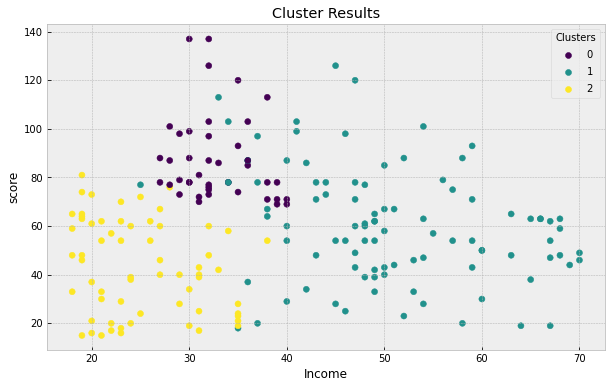

In [22]:
# Create scatter plot of data points colored by cluster label
fig, ax = plt.subplots()
scatter = ax.scatter(customers['age'], customers['Income'], c=customers['cluster'])

# Add legend
legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")

# Add labels and title
ax.set_xlabel('Income')
ax.set_ylabel('score')
ax.set_title('Cluster Results')

In [24]:
# The result is not very clear
px.scatter(customers, x='Income', y='age', color='cluster')

In [28]:
# Let's check each cluster individually
# It seems that the variable who defines the cluster is the income
# We can have here three cluster divide by: low, middle and high income
(customers[customers['cluster'] == 0]).mean(numeric_only=True)

age        32.85
Income     87.34
score      79.98
cluster     0.00
dtype: float64

In [29]:
(customers[customers['cluster'] == 1]).mean(numeric_only=True)

age        50.41
Income     60.47
score      33.34
cluster     1.00
dtype: float64

In [30]:
(customers[customers['cluster'] == 2]).mean(numeric_only=True)

age        25.14
Income     43.27
score      56.51
cluster     2.00
dtype: float64